In [1]:
# Dependencies
import requests
import numpy as np
import pandas as pd
from census import Census
import matplotlib.pyplot as plt
from api_keys import census_key
from pathlib import Path
import scipy.stats as st

In [2]:
# Creates an instance of the Census library
income_census = Census(
    census_key,
    year = 2017
)

# Heart Disease Diagnosis Rates vs. Per Capita Income By State

In [3]:
# Runs Census search to retrieve data on all states
state_income_census_data = income_census.acs5.get(
    (
        "NAME",
        "B19301_001E"
    ),
    {'for': 'state:*'}
)

# Converts data to DataFrame
state_income_census_pd = pd.DataFrame(state_income_census_data)

# Renames the columns
state_income_census_pd = state_income_census_pd.rename(
    columns = {"B19301_001E": "Per Capita Income"
              }
)

In [4]:
# Creates a dictionary of states and their per capita income
income_state_dict = state_income_census_pd[['NAME', 'Per Capita Income']].set_index('NAME').to_dict()

# Removes the per capita income index from the dictionary so the dictionary can later be applied to the heart disease DataFrame
income_state_dict = income_state_dict.pop('Per Capita Income')

In [5]:
# Retrieves and reads .csv data
heart_income_csv = Path('Data/500_Cities__Coronary_heart_disease_among_adults_aged___18_years_20240314.csv')
heart_income_csv = pd.read_csv(heart_income_csv)

# Isolates the columns that are relevant to our analysis
heart_income_df = heart_income_csv[['StateDesc', 'CityName', 'Data_Value', 'UniqueID', 'PopulationCount', 'Data_Value_Type']]

# Sorts our DataFrame by population and data value type in descending order
heart_income_df = heart_income_df.sort_values(['PopulationCount', 'Data_Value_Type'], ascending=False)

# Removes duplicated city IDs, keeping the first occurence of each ID that has the highest population
# and crude prevalence data type
heart_income_df = heart_income_df.drop_duplicates(subset=['UniqueID'])
heart_income_df = heart_income_df[['StateDesc', 'CityName', 'Data_Value']]

heart_income_df

,StateDesc,CityName,Data_Value
2848,United States,NaN,6.4
18849,New York,New York,5.4
3646,California,Los Angeles,4.8
11156,Illinois,Chicago,5.2
25607,Texas,Houston,5.4
...,...,...,...
27285,Utah,Salt Lake City,NaN
27627,Virginia,Norfolk,NaN
27758,Utah,Salt Lake City,NaN
28721,Wisconsin,Madison,NaN


In [6]:
# Adds a duplicate StateDesc column
heart_income_df['Per Capita Income'] = heart_income_df.loc[:, 'StateDesc']

# Uses the dictionary to replace each state name in the duplicated column with each state's respective per capita income values
# Renames the duplicated column to Per Capita Income
heart_income_df['Per Capita Income'] = heart_income_df['Per Capita Income'].map(income_state_dict)

# Drops all rows that contain null values
heart_income_df = heart_income_df.dropna()
heart_income_df

,StateDesc,CityName,Data_Value,Per Capita Income
18849,New York,New York,5.4,35752.0
3646,California,Los Angeles,4.8,33128.0
11156,Illinois,Chicago,5.2,32924.0
25607,Texas,Houston,5.4,28985.0
22521,Pennsylvania,Philadelphia,6.5,31476.0
...,...,...,...,...
4965,California,Redlands,6.6,33128.0
16253,Nevada,Henderson,5.7,28450.0
21449,Oklahoma,Oklahoma City,7.4,26461.0
23544,Tennessee,Chattanooga,6.5,27277.0


The correlation coefficient between per capita income and heart disease is -0.18.
There is no correlation between income and heart disease rates.


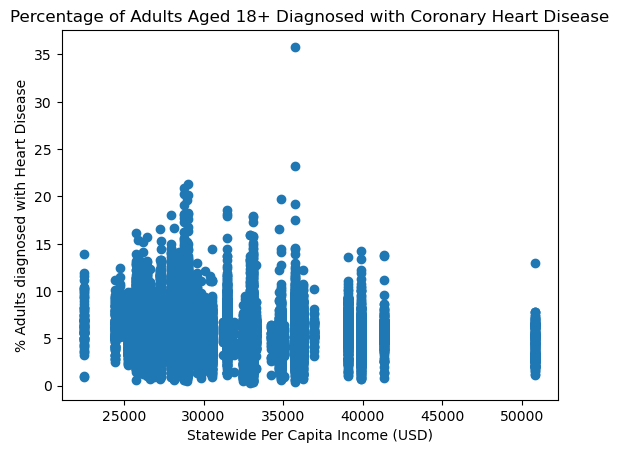

In [7]:
# Calculates the correlation coefficient between income and heart disease rates
income_correlation = st.pearsonr(heart_income_df['Per Capita Income'], heart_income_df['Data_Value'])

# Generates a scatter plot of income vs. heart disease rates
plt.scatter(heart_income_df['Per Capita Income'], heart_income_df['Data_Value'])
plt.xlabel('Statewide Per Capita Income (USD)')
plt.ylabel('% Adults diagnosed with Heart Disease')
plt.title('Percentage of Adults Aged 18+ Diagnosed with Coronary Heart Disease')

# Prints our analysis
print(f'The correlation coefficient between per capita income and heart disease is {round(income_correlation[0],2)}.')
print(f'There is no correlation between income and heart disease rates.')
plt.show()

# Heart Disease Diagnosis Rates vs. Per Capita Income By County

In [8]:
# Runs Census search to retrieve data on all counties in the US
county_income_census_data = income_census.acs5.get(
    (
        "NAME",
        "B19301_001E"
    ),
    {'for': 'county:*'}
)

# Converts data to DataFrame
county_income_census_pd = pd.DataFrame(county_income_census_data)

# Renames the columns
county_income_census_pd = county_income_census_pd.rename(
    columns = {"B19301_001E": "Per Capita Income"
              }
)
county_income_census_pd

,NAME,Per Capita Income,state,county
0,"Ellis County, Oklahoma",27272.0,40,045
1,"Grady County, Oklahoma",27334.0,40,051
2,"Payne County, Oklahoma",22785.0,40,119
3,"Pottawatomie County, Oklahoma",22284.0,40,125
4,"Creek County, Oklahoma",24056.0,40,037
...,...,...,...,...
3215,"Pontotoc County, Oklahoma",23862.0,40,123
3216,"Roger Mills County, Oklahoma",27797.0,40,129
3217,"Woodward County, Oklahoma",27413.0,40,153
3218,"Cherokee County, Oklahoma",19799.0,40,021


In [9]:
# Splits the county names of the county DataFrame to isolate the county's name and state
county_income_census_pd[['NAME', 'state']] = county_income_census_pd['NAME'].str.split(' County, ', n=1, expand=True)
county_income_census_pd

,NAME,Per Capita Income,state,county
0,Ellis,27272.0,Oklahoma,045
1,Grady,27334.0,Oklahoma,051
2,Payne,22785.0,Oklahoma,119
3,Pottawatomie,22284.0,Oklahoma,125
4,Creek,24056.0,Oklahoma,037
...,...,...,...,...
3215,Pontotoc,23862.0,Oklahoma,123
3216,Roger Mills,27797.0,Oklahoma,129
3217,Woodward,27413.0,Oklahoma,153
3218,Cherokee,19799.0,Oklahoma,021


In [15]:
# Isolates the relevant columns for our analysis and renames columns to prepare for merging
county_income_census_pd = county_income_census_pd[['NAME', 'Per Capita Income', 'state']].rename(columns={'NAME':'county_name',
                                                                                                         'state':'state_name'})
                                           

In [10]:
# Generates a DataFrame containing all cities in the US and the counties/states they belong to
city_county_csv = Path('Data/uscities.csv')
city_county_csv = pd.read_csv(city_county_csv)
city_county_df = city_county_csv[['city', 'state_name', 'county_name']]
city_county_df

,city,state_name,county_name
0,New York,New York,Queens
1,Los Angeles,California,Los Angeles
2,Chicago,Illinois,Cook
3,Miami,Florida,Miami-Dade
4,Houston,Texas,Harris
...,...,...,...
31115,Kohatk,Arizona,Pinal
31116,Ironville,Pennsylvania,Blair
31117,Newkirk,New Mexico,Guadalupe
31118,Falcon Village,Texas,Starr


In [11]:
# Generates a DataFrame containing all of the cities included in the heart disease study and
# their respective states
heart_cities_df = heart_income_csv[['CityName', 'StateDesc']].drop_duplicates(subset=['CityName', 'StateDesc'])

# Renames columns for merging
heart_cities_df = heart_cities_df.rename(columns={'CityName':'city', 'StateDesc':'state_name'})

# Merges our DataFrames to produce a new DataFrame containing only our studied cities, their states,
# and their counties
merged_heart_cities_df = heart_cities_df.merge(city_county_df, how='left')

# Checks our merged DataFrame for null values
# https://stackoverflow.com/questions/14247586/how-to-select-rows-with-one-or-more-nulls-from-a-pandas-dataframe-without-listin
merged_heart_cities_df[merged_heart_cities_df.isnull().any(axis=1)]

,city,state_name,county_name
59,NaN,United States,NaN
162,San Buenaventura (Ventura),California,NaN
255,Boise City,Idaho,NaN


In [12]:
# Identifies the city name used in city_county_df so that the null value above can be resolved
city_county_df.loc[city_county_df['city']=='San Buenaventura']

,city,state_name,county_name
416,San Buenaventura,California,Ventura


In [13]:
# Identifies the city name used in city_county_df so that the null value above can be resolved
city_county_df.loc[city_county_df['city']=='Boise']

,city,state_name,county_name
96,Boise,Idaho,Ada


In [14]:
# Replaces the mismatched city names
heart_cities_df = heart_cities_df.replace('San Buenaventura (Ventura)', 'San Buenaventura').replace('Boise City', 'Boise')

# Drops the remaining row with a null values
heart_cities_df = heart_cities_df.dropna()

# Creates a new, corrected DataFrame with no null values
corrected_heart_cities_df = heart_cities_df.merge(city_county_df, how='left')

In [16]:
# Merges the DataFrame containing the studied cities/states/counties and the DataFrame
# containing the income values for each county
reduced_county_income = corrected_heart_cities_df.merge(county_income_census_pd, how='left')

# Drops the rows with null values since we don't have per capita income data for these locations
reduced_county_income = reduced_county_income.dropna()

reduced_county_income

,city,state_name,county_name,Per Capita Income
0,Hayward,California,Alameda,41363.0
1,Huntsville,Alabama,Madison,34232.0
2,Chandler,Arizona,Maricopa,30186.0
3,Surprise,Arizona,Maricopa,30186.0
4,Bellflower,California,Los Angeles,30798.0
...,...,...,...,...
495,Appleton,Wisconsin,Outagamie,30858.0
496,Green Bay,Wisconsin,Brown,29874.0
497,Kenosha,Wisconsin,Kenosha,28996.0
498,Cheyenne,Wyoming,Laramie,31554.0


In [17]:
# Creates a dictionary from the DataFrame created above which contains 
# a city key and a per capita income value
county_income_dict = reduced_county_income[['city', 'Per Capita Income']].set_index('city').to_dict()

# Removes 'Per Capita Income' index from the dictionary for later processing
county_income_dict = county_income_dict.pop('Per Capita Income')

In [18]:
# References the DataFrame we created in the statewide summary
income_summary = heart_income_df[['StateDesc', 'CityName', 'Data_Value']]

# Duplicates the CityName column of this DataFrame and renames the duplicated column 'Per Capita Income'
income_summary['Per Capita Income'] = income_summary.loc[:, 'CityName']

# Uses the dictionary created above to replace the values in the duplicated row with
# each city's countywide per capita income
income_summary['Per Capita Income'] = income_summary['Per Capita Income'].map(county_income_dict)

# Drops the null values in the DataFrame where per capita income data was unavailable
income_summary = income_summary.dropna()

income_summary

,StateDesc,CityName,Data_Value,Per Capita Income
18849,New York,New York,5.4,28814.0
3646,California,Los Angeles,4.8,30798.0
11156,Illinois,Chicago,5.2,33722.0
25607,Texas,Houston,5.4,30856.0
22521,Pennsylvania,Philadelphia,6.5,24811.0
...,...,...,...,...
4965,California,Redlands,6.6,22867.0
16253,Nevada,Henderson,5.7,27719.0
21449,Oklahoma,Oklahoma City,7.4,29127.0
23544,Tennessee,Chattanooga,6.5,29711.0


The correlation coefficient between per capita income and heart disease is -0.18.
There is no correlation between income and heart disease rates.


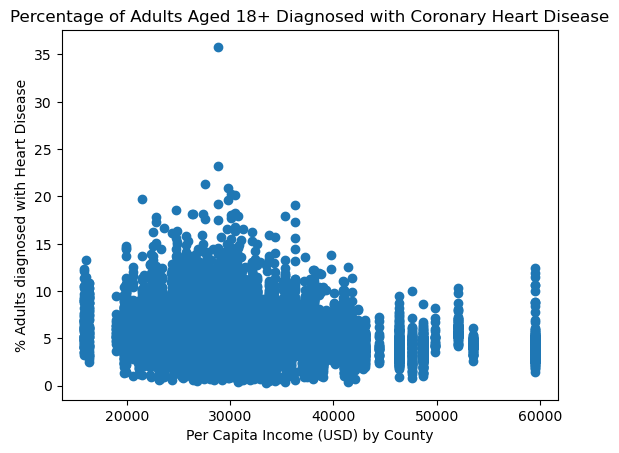

In [19]:
# Calculates the correlation coefficient between income and heart disease rates
county_income_correlation = st.pearsonr(income_summary['Per Capita Income'], income_summary['Data_Value'])

# Generates a scatter plot of income vs. heart disease rates
plt.scatter(income_summary['Per Capita Income'], income_summary['Data_Value'])
plt.xlabel('Per Capita Income (USD) by County')
plt.ylabel('% Adults diagnosed with Heart Disease')
plt.title('Percentage of Adults Aged 18+ Diagnosed with Coronary Heart Disease')

# Prints our analysis
print(f'The correlation coefficient between per capita income and heart disease is {round(income_correlation[0],2)}.')
print(f'There is no correlation between income and heart disease rates.')
plt.show()

## In Summary

### Conclusions

The data used in this analysis suggests that there may be no correlation between income and heart disease diagnosis rates. However, there are limitations of this analysis that warrant further investigation.

### Limitations

The study conducted on heart disease rates stated that this data was collected from the 500 largest cities in the US.  Given that large, metropolitan areas tend to have higher incomes than average, this analysis may not have had any data representative of truly low income areas.

The per capita income data for this analysis was only obtained for the state and county levels.  The countywide per capita incomes are just an approximation of each city's income and may not fully represent the actual per capita incomes of each city.